In [30]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torchaudio
import torch
from transformers import pipeline
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import os
import pandas as pd

In [5]:
PATH = "/kaggle/input/cremad/AudioWAV"
dir_list = os.listdir(PATH) 
dir_list.sort()

**Data processing**

Reading the dataset, and organizing the emotions 

In [102]:
labels = []
path = []
for i in dir_list:
    path.append(PATH + '/' + i)
    if 'ANG' in i:
        labels.append('angry')
    elif 'DIS' in i:
        labels.append('disgust')
    elif 'FEA' in i:
        labels.append('fear')
    elif 'HAP' in i:
        labels.append('happy')
    elif 'NEU' in i:
        labels.append('neutral')
    elif 'SAD' in i:
        labels.append('sad')
    else:
        labels.append('unknown')

emotion_df = pd.DataFrame(labels, columns=['Emotions'])

path_df = pd.DataFrame(path, columns=['Path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)

In [104]:
crema_df['Emotions'] = crema_df['Emotions'].astype(str)

Generating the MFCC features for each audio and storing it in a dataframe with the label for each emotion

In [107]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
crema_df.replace({'Emotions':labels},inplace=True)
num_mfcc = 13
n_fft = 2048
hop_length = 512
SAMPLE_RATE = 22050
data = {
    "labels": [],
    "mfcc": []
}

for i in range(7442):
    data['labels'].append(crema_df.iloc[i, 0])
    signal, sample_rate = librosa.load(crema_df.iloc[i, 1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i % 500 == 0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [100]:
import tensorflow as tf

Padding the MFCC features so they all have the same size (216)

In [129]:
X = np.asarray(data['mfcc'], dtype="object")
y = np.asarray(data["labels"], dtype="object")
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 216, 13)

Splitting the data for training, testing and validation

In [21]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [132]:
X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)

y_train_class = to_categorical(y_train, 6)
y_val_class = to_categorical(y_val, 6)

In [133]:
X_train.shape

(6548, 216, 13)

Implementing an LSTM model 

In [134]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks
MODEL = Sequential()
MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=(X.shape[1:3])))
MODEL.add(layers.LSTM(64))
MODEL.add(layers.Dense(6, activation='softmax'))

print(MODEL.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 216, 64)           19968     
                                                                 
 lstm_12 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 6)                 390       
                                                                 
Total params: 53382 (208.52 KB)
Trainable params: 53382 (208.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [135]:
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.01, patience=100)
MODEL.compile(loss='categorical_crossentropy', optimizer='RMSProp', metrics=['categorical_accuracy'])
model = MODEL.fit(X_train, y_train_class, epochs=200, batch_size=6, validation_data=(X_val, y_val_class))

Epoch 1/200
1092/1092 [==============================] - 27s 15ms/step - loss: 1.5280 - categorical_accuracy: 0.3590 - val_loss: 1.4658 - val_categorical_accuracy: 0.3952
Epoch 2/200
1092/1092 [==============================] - 15s 14ms/step - loss: 1.4517 - categorical_accuracy: 0.3937 - val_loss: 1.3950 - val_categorical_accuracy: 0.4304
Epoch 3/200
1092/1092 [==============================] - 15s 14ms/step - loss: 1.4260 - categorical_accuracy: 0.4171 - val_loss: 1.3302 - val_categorical_accuracy: 0.4848
Epoch 4/200
1092/1092 [==============================] - 15s 14ms/step - loss: 1.4092 - categorical_accuracy: 0.4297 - val_loss: 1.3612 - val_categorical_accuracy: 0.4320
Epoch 5/200
1092/1092 [==============================] - 15s 14ms/step - loss: 1.3725 - categorical_accuracy: 0.4452 - val_loss: 1.3363 - val_categorical_accuracy: 0.4656
Epoch 6/200
1092/1092 [==============================] - 15s 14ms/step - loss: 1.3532 - categorical_accuracy: 0.4456 - val_loss: 1.3454 - val_cat

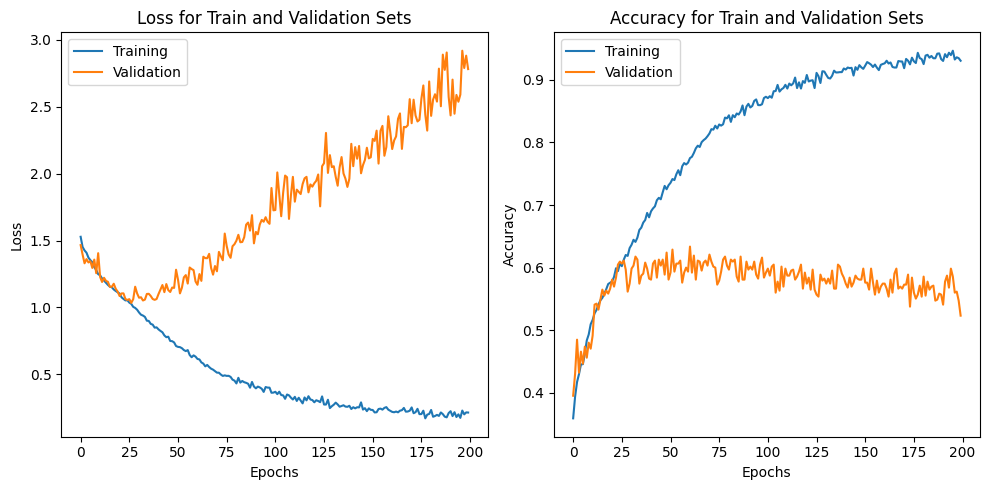

In [136]:
from sklearn.metrics import confusion_matrix
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model.history['loss'])
axes[0].plot(model.history['val_loss'])
axes[0].set_title('Loss for Train and Validation Sets')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model.history['categorical_accuracy'])
axes[1].plot(model.history['val_categorical_accuracy'])
axes[1].set_title('Accuracy for Train and Validation Sets')
axes[1].set_ylabel('Accuracy')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

20/20 [==============================] - 1s 12ms/step


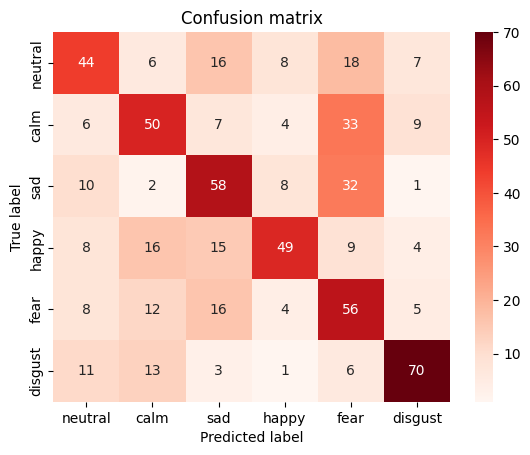

In [137]:
import seaborn as sns

y_pred = np.argmax(MODEL.predict(X_val), axis=1)
labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']
cm = confusion_matrix(np.argmax(y_val_class, axis=1), y_pred, labels=range(6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix')
plt.show()

In [140]:
from sklearn.metrics import classification_report
# Make predictions on test set
#Y_pred = MODEL.predict(X_val)
#Y_pred = [np.argmax(i) for i in Y_pred]
# Print the metrics
print(classification_report(np.argmax(y_val_class, axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47        99
           1       0.51      0.46      0.48       109
           2       0.50      0.52      0.51       111
           3       0.66      0.49      0.56       101
           4       0.36      0.55      0.44       101
           5       0.73      0.67      0.70       104

    accuracy                           0.52       625
   macro avg       0.55      0.52      0.53       625
weighted avg       0.54      0.52      0.53       625

